In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import cv2 as cv
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, Model
from keras.applications import VGG16
from keras.layers import Activation, Flatten,LeakyReLU, Dropout, Dense, MaxPooling2D, Conv2D, SeparableConv2D, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
file_name = [f for f in os.listdir("/content/IDC_regular_ps50_idx5")]
DATADIR = '/content/IDC_regular_ps50_idx5'
CATEGORIES = ['0','1']

In [0]:
full_data = []

def create_training_data():
    for file in file_name:
        
        for categories in CATEGORIES:
            path = os.path.join(DATADIR,file, categories)
            n_class = CATEGORIES.index(categories)
            for images in os.listdir(path):
                try:
                    image_array = cv.imread(os.path.join(path,images), cv.IMREAD_COLOR)

                    new_array = cv.resize(image_array,(50, 50))
                    full_data.append([new_array, n_class])
                except Exception as e:
                    pass

create_training_data()

In [4]:
len(full_data)

277524

In [0]:
random.shuffle(full_data)

In [6]:
feature_data = []
label_data = []

for feature, label in full_data:
    feature_data.append(feature)
    label_data.append(label)
    
print('Length of feature_data :',len(feature_data))
print('Length of label_data :',len(label_data))

Length of feature_data : 277524
Length of label_data : 277524


## Reshaping the data

In [7]:
feature_data = np.array(feature_data).reshape(-1,50,50,3)
print('Shape of feature_data :',feature_data.shape)


Shape of feature_data : (277524, 50, 50, 3)


## Encoding of Label data

In [8]:
#dividing dataset for train and test
xtrain,xtest, ytrain,ytest = train_test_split(feature_data, label_data, test_size=.25, random_state=0)
print('Shape of xtrain :',xtrain.shape)
print('Shape of xtest :',xtest.shape)
print('Length of ytrain :',len(ytrain))
print('Length of ytest :',len(ytest))

Shape of xtrain : (208143, 50, 50, 3)
Shape of xtest : (69381, 50, 50, 3)
Length of ytrain : 208143
Length of ytest : 69381


In [9]:
#convert label to one hot encoding
ytrain_one_hot = to_categorical(ytrain, num_classes=2)
ytest_one_hot = to_categorical(ytest, num_classes=2)
print(ytrain_one_hot[1])
print(ytest_one_hot[1])

[1. 0.]
[1. 0.]


In [10]:
#dividing train data into train and valid
Xtrain,xvalid, Ytrain,yvalid = train_test_split(xtrain,ytrain_one_hot, test_size=.1, random_state=0)
print('Shape of Xtrain :',Xtrain.shape)
print('Shape of xvalid :',xvalid.shape)
print('Length of Ytrain :',len(Ytrain))
print('Length of yvalid :',len(yvalid))

Shape of Xtrain : (187328, 50, 50, 3)
Shape of xvalid : (20815, 50, 50, 3)
Length of Ytrain : 187328
Length of yvalid : 20815


## Model

In [0]:
model=Sequential()
model.add(Conv2D(32, (3,3), padding="same",input_shape=(50,50,3)))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [0]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=["accuracy"])


In [0]:
trainAug = ImageDataGenerator(rescale=1/255.0,
                              rotation_range=20,
                              zoom_range=0.05,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.05,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest",
#      featurewise_center=True, featurewise_std_normalization=True
      )
trainAug.fit(Xtrain)


valAug=ImageDataGenerator(rescale=1/255.0,
                          rotation_range=20,
                          zoom_range=0.05,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          shear_range=0.05,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode="nearest",
                          )
valAug.fit(xvalid)

testAug=ImageDataGenerator(rescale=1/255.0)
testAug.fit(xtest)


In [15]:
model_history=model.fit_generator(trainAug.flow(Xtrain,Ytrain, batch_size=64),
                      steps_per_epoch=len(Xtrain) / 32,
                      epochs=5, validation_data=valAug.flow(xvalid,yvalid),
                      validation_steps=len(xvalid)/32
                      ) 

Epoch 1/5
5854/5854 [==============================] - 449s 77ms/step - loss: 0.4400 - accuracy: 0.8252 - val_loss: 2.4663 - val_accuracy: 0.3887
Epoch 2/5
5854/5854 [==============================] - 441s 75ms/step - loss: 0.3305 - accuracy: 0.8605 - val_loss: 0.3359 - val_accuracy: 0.7932
Epoch 3/5
5854/5854 [==============================] - 442s 75ms/step - loss: 0.3123 - accuracy: 0.8684 - val_loss: 0.5561 - val_accuracy: 0.8611
Epoch 4/5
5854/5854 [==============================] - 440s 75ms/step - loss: 0.3018 - accuracy: 0.8733 - val_loss: 0.1143 - val_accuracy: 0.8657
Epoch 5/5
5854/5854 [==============================] - 443s 76ms/step - loss: 0.2936 - accuracy: 0.8772 - val_loss: 0.2381 - val_accuracy: 0.8671


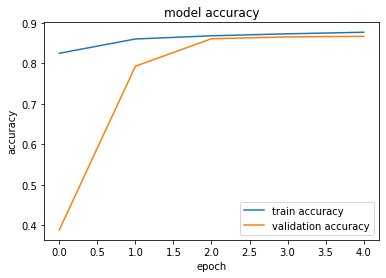

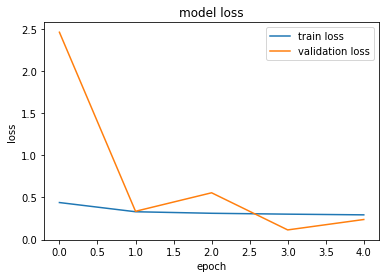

In [16]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='best')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='best')
plt.show()

In [0]:
predicted=model.predict(testAug.flow(xtest))
predicted=np.argmax(predicted,axis=1)

In [18]:
predicted

array([0, 0, 0, ..., 0, 1, 0])